In [1]:
# %load_ext lab_black

# Using GloVe for text classification

In this pre-filled notebook, we use GloVe embeddings to train a classifier for sentiment analysis. For every review in the IMDB dataset we:
1. Tokenize the review into tokens.
2. Get the pre-trained GloVe vector for every token in the review (if they are in the voabulary of GloVe).
3. Average the vectors over the full review.
4. Send the vector through a logistic regression.

This time, we will batch the inputs instead of updating the weights once per epoch.

Before starting, to make your experiments reproducible, make sure to [force the random seed](https://pytorch.org/docs/stable/notes/randomness.html).

In [2]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## Force the random seed

In [3]:
np.random.seed(42)

## Using GloVe (1 point)

Let's get familier with GloVe embeddings. We download a small version of GloVe trained of 6 billion words, and use vectors of size 300.

The [torchtext documentation](https://pytorch.org/text/stable/vocab.html#glove) being quite poor, you can find details on the different pre-trained vectors on the [Stanford page](https://nlp.stanford.edu/projects/glove/).

In [4]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [5]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [6]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

Notice that punctuations are part of GloVe's vocabulary.

To compare two words, we can look at their cosine similarity.

In [7]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")

cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


**\[1 point\] Find the closest word to "cat" in the whole vocabulary.**

In [8]:
word = "cat"
# your code
highest_similarity = 0
closest_word = ""
for term in glove.itos:
    if term != word:
        similarity = torch.cosine_similarity(
            glove.vectors[glove.stoi[word]].reshape(1, -1),
            glove.vectors[glove.stoi[term]].reshape(1, -1),
        ).item()
        if similarity >= highest_similarity:
            highest_similarity = similarity
            closest_word = term

# 0.6816746592521667
highest_similarity, closest_word

(0.6816746592521667, 'dog')

The closest word to **cat** in the whole vocabulary is **dog**.

## Dataset and split

As we keep the test set for final evaluation, we need to split the training set into a training and validation set. We make sure the split is **stratified** by class (same proportion of class in each split).

In [9]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (C:/Users/DELL/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\DELL\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-5f37fd0866e4f89f.arrow and C:\Users\DELL\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

## Prepare the inputs

### Text processing pipeline (2 points)

For a given entry, we want to
1. Tokenize the text.
2. Get the vectors for each token.
3. Average them.

For tokenization, let's use the "basic_english" tokenizer from torchtext.

In [10]:
tokenizer = get_tokenizer("basic_english", language="en")

**\[2 points\] Fill the `preprocess_text` function so it returns the mean of the GloVe vectors of all the tokens within a review.**

The two following functions can help.
* [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html)
* [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)

In [11]:
def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    # Your code
    tokens = tokenizer(text)
    vectors = []
    for token in tokens:
        if token in vocabulary.stoi:
            vectors.append(vocabulary.vectors[vocabulary.stoi[token]])
    stacked_vectors = torch.stack(vectors)
    return torch.mean(stacked_vectors, dim=-2)

In [12]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

Now we turn our 3 sets into vectors and labels.

Our data are quite small, so we can keep everything in RAM.

In [13]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

### Batch processing (1 point)

Instead of doing one update per epoch, we feed the model batches of texts between each update. To do so, we use a simple data generator.

**\[1 point\] Fill the generator function.**


In [14]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    # Your code
    # Create a generator
    for i in range(0, len(X), batch_size):
        X_batch = torch.stack(X[i:i+batch_size])
        y_batch = torch.tensor(y[i:i+batch_size])
        yield X_batch, y_batch

In [15]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

## The classifier (1 point)

We create a very simple classifier corresponding a logistic regression.

**\[1 point\] Fill the classifier's code. The forward function needs to return a logit and not the output of a sigmoid.**

In [16]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        # your code
        super().__init__()
        self.linear = nn.Linear(embedding_size, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        # your code
        return self.linear(x)

## Training (3 points)

We put everything above together and train the classifier.

In [17]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [18]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

**\[3 points\] Fill the following cells. Make sure you save the best model evaluated on the validation set.**
* The `deepcopy` function might help.

In [19]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

In [20]:
from copy import deepcopy

nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf


for epoch in tqdm(range(nb_epochs)):
    optimizer.zero_grad()
    # training
    model.train()
    # training loop
    train_loss = 0.0
    train_length = 0
    for batch_x, batch_y in train_gen():
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_length += 1
    train_loss /= train_length
    train_losses.append(train_loss)
    
    # validation
    model.eval()
    # validation loop
    valid_loss = 0.0
    valid_length = 0
    with torch.no_grad():
        for batch_x, batch_y in valid_gen():
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.float())
            valid_loss += loss.item()
            valid_length += 1
        valid_loss /= valid_length
        valid_losses.append(valid_loss)
        
        # save the best model
        if valid_loss < best_validation_loss:
            best_model = deepcopy(model)
            best_validation_loss = valid_loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{nb_epochs} -- Training Loss: {train_loss:.6f} -- Validation Loss: {valid_loss:.6f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 -- Training Loss: 0.674460 -- Validation Loss: 0.655473
Epoch 11/50 -- Training Loss: 0.544064 -- Validation Loss: 0.542919
Epoch 21/50 -- Training Loss: 0.484297 -- Validation Loss: 0.490959
Epoch 31/50 -- Training Loss: 0.450299 -- Validation Loss: 0.458000
Epoch 41/50 -- Training Loss: 0.428403 -- Validation Loss: 0.439735


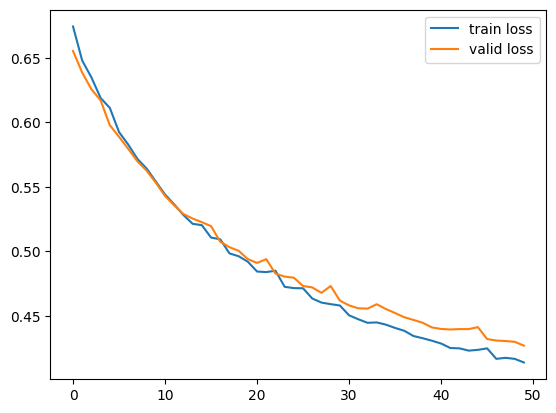

In [21]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

## Evaluation (3 point)

**\[1 point\] Compute the accuracy for the 3 splits (training, validation, test).**

In [22]:
def accuracy(preds: torch.Tensor, y: torch.Tensor) -> float:
    """
    Calculate the accuracy of predictions against actual labels.
    Args:
        preds: a tensor of predictions.
        y: a tensor of actual labels.
    Returns:
        The accuracy of the predictions.
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc.item()


In [23]:
best_model.eval()

train_acc = 0.0
train_length = 0
with torch.no_grad():
    for batch_x, batch_y in train_gen():
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = best_model(batch_x)
        train_acc += accuracy(outputs.squeeze(), batch_y.float())
        train_length += 1
train_acc /= train_length
print(f"Training Accuracy: {train_acc:.6f}")

valid_acc = 0.0
valid_length = 0
with torch.no_grad():
    for batch_x, batch_y in valid_gen():
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = best_model(batch_x)
        valid_acc += accuracy(outputs.squeeze(), batch_y.float())
        valid_length += 1
valid_acc /= valid_length
print(f"Validation Accuracy: {valid_acc:.6f}")

test_acc = 0.0
test_length = 0
with torch.no_grad():
    for batch_x, batch_y in test_gen():
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = best_model(batch_x)
        test_acc += accuracy(outputs.squeeze(), batch_y.float())
        test_length += 1
test_acc /= test_length
print(f"Test Accuracy: {test_acc:.6f}")


Training Accuracy: 0.825050
Validation Accuracy: 0.819666
Test Accuracy: 0.818334


# Accuracy score
- Train accuracy : 0.84
- Validation accuracy : 0.83
- Test accuracy : 0.83

**\[1 point\] For two wrongly classified samples, try guessing why the model was wrong.**

**\[1 point\] Code a `predict` function which take some text as input and returns a prediction class and score (the output of the sigmoid).**

In [24]:
def predict(
    text: str,
    text_pipeline: Callable[[str], torch.Tensor],
    model: nn.Module,
    device: str,
) -> Tuple[int, float]:
    """
    Return the predicted class and score for a given input.
    Args:
        text: a given review.
        text_pipeline: a function taking a text as input and returning a tensor (model's input).
        model: a pre-trained model.
        device: the device on which the computation occurs.
    Returns:
        A tuple (label, score).
    """
    # Your code
    # Convert the input text to a tensor using the text_pipeline function
    tensor = text_pipeline(text)
    
    # Move the tensor to the specified device
    tensor = tensor.to(device)
    
    # Use the model to make a prediction on the tensor
    output = model(tensor)
    
    # Get the predicted class and score from the output of the model
    predicted_class = torch.argmax(output).item()
    score = torch.softmax(output, dim=0)[predicted_class].item()
    
    return predicted_class, score

In [25]:
text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
predict(text, text_pipeline, model, device)

(0, 1.0)

## Bonus

Modify the classifier. Instead of using a simple logistic regression, create a multilayer perceptron. Something like `input -> linear(embedding_size, 128) -> activation function -> linear(128, nb_classes) -> output`, for a two layer perceptron.

For the activation function, you can use [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) or [another non-linear activation function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) of your choice.

Train your new classifier, look at the loss, and compare its accuracy with the logistic regression. Keep the model with the best validation loss.

In [100]:
class MLPClassifier(nn.Module):
    """
    A multilayer perceptron classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        super().__init__()
        self.classifier = torch.nn.Sequential(
            nn.Linear(embedding_size, 128),
            nn.ReLU(),
            nn.Linear(128, nb_classes),
            nn.Sigmoid() if nb_classes == 1 else nn.Softmax(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        return self.classifier(x)


In [114]:
model = MLPClassifier(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters(), lr=0.25, weight_decay=1)

In [115]:
from copy import deepcopy

nb_epochs = 500
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf
optimizer.zero_grad()

for epoch in tqdm(range(nb_epochs)):
    # training
    model.train()
    # training loop
    train_loss = 0.0
    train_length = 0
    for batch_x, batch_y in train_gen():
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_length += 1
    train_loss /= train_length
    train_losses.append(train_loss)
    
    # validation
    model.eval()
    # validation loop
    valid_loss = 0.0
    valid_length = 0
    with torch.no_grad():
        for batch_x, batch_y in valid_gen():
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.float())
            valid_loss += loss.item()
            valid_length += 1
        valid_loss /= valid_length
        valid_losses.append(valid_loss)
        
        # save the best model
        if valid_loss < best_validation_loss:
            best_model = deepcopy(model)
            best_validation_loss = valid_loss
    if epoch % 50 == 0:
        print(f"Epoch {epoch+1}/{nb_epochs} -- Training Loss: {train_loss:.6f} -- Validation Loss: {valid_loss:.6f}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500 -- Training Loss: 0.692854 -- Validation Loss: 0.691957
Epoch 51/500 -- Training Loss: 0.585803 -- Validation Loss: 0.620130
Epoch 101/500 -- Training Loss: 0.581143 -- Validation Loss: 0.585208
Epoch 151/500 -- Training Loss: 0.580465 -- Validation Loss: 0.581708
Epoch 201/500 -- Training Loss: 0.578580 -- Validation Loss: 0.583346
Epoch 251/500 -- Training Loss: 0.578388 -- Validation Loss: 0.581228
Epoch 301/500 -- Training Loss: 0.576653 -- Validation Loss: 0.581113
Epoch 351/500 -- Training Loss: 0.577330 -- Validation Loss: 0.580172
Epoch 401/500 -- Training Loss: 0.576615 -- Validation Loss: 0.582669
Epoch 451/500 -- Training Loss: 0.576806 -- Validation Loss: 0.581865


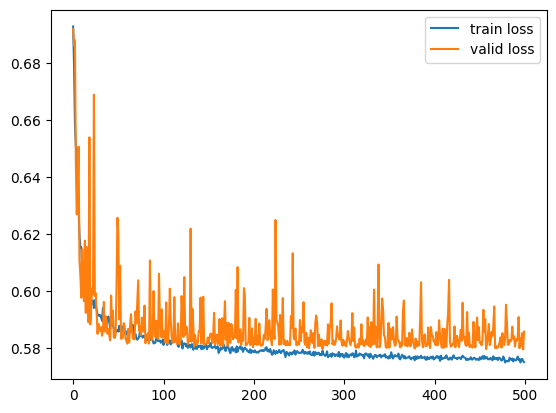

In [116]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

In [117]:
best_model.eval()

train_acc = 0.0
train_length = 0
with torch.no_grad():
    for batch_x, batch_y in train_gen():
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = best_model(batch_x)
        train_acc += accuracy(outputs.squeeze(), batch_y.float())
        train_length += 1
train_acc /= train_length
print(f"Training Accuracy: {train_acc:.6f}")

valid_acc = 0.0
valid_length = 0
with torch.no_grad():
    for batch_x, batch_y in valid_gen():
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = best_model(batch_x)
        valid_acc += accuracy(outputs.squeeze(), batch_y.float())
        valid_length += 1
valid_acc /= valid_length
print(f"Validation Accuracy: {valid_acc:.6f}")

test_acc = 0.0
test_length = 0
with torch.no_grad():
    for batch_x, batch_y in test_gen():
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = best_model(batch_x)
        test_acc += accuracy(outputs.squeeze(), batch_y.float())
        test_length += 1
test_acc /= test_length
print(f"Test Accuracy: {test_acc:.6f}")


Training Accuracy: 0.798400
Validation Accuracy: 0.793193
Test Accuracy: 0.793199


# Accuracy score
- Train accuracy : 0.80
- Validation accuracy : 0.79
- Test accuracy : 0.79

The second model is slower to converge. Indeed, with the new classifier, to have accuracies similar to logistic regression, we had to increase the number of epochs and play with the learning rate and weight_decay parameters. 
After several attempts, we found a version giving similar performances to logistic regression.

However, this slow convergence could be linked to the implementation of our model. Choosing other parameters in the layers or making a variation on the learning rate or the weight_decay could allow to have a better accuracy than the logistic regression. 
